In [4]:
import os
os.listdir("/kaggle/input/prefetch-data-final-2")

['data_lbm.csv', 'data_sphinx3.csv', 'data_xalancbmk.csv']

In [5]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.46.0-py3-none-any.whl size=17278 sha256=3568bbb40e5241c58a6ff463d7e6364ed6b44a2f9712104b3e77814495b283e3
  Stored in directory: /root/.cache/pip/wheels/ec/f7/48/30de93f8333298bad9202aab9b04db0cfd58dcd379b5a5ef1c
Successfully built keras-self-attention


In [6]:
import keras
from keras_self_attention import SeqSelfAttention

Using TensorFlow backend.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk import ngrams
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import tensorflow.keras.backend as K
from keras.utils import to_categorical
from collections import Counter
import json


ROOT_DIR = "/kaggle/input/prefetch-data-final-2/"

def get_memory_addr_line(line):
    addr = 0
    ip = 0
    tokens = line.split("\t")
    if len(tokens)==2:
        try:
            addr = int(tokens[1].strip())
            ip = int(tokens[0].strip())
        except:
            print("Error parsing...")
            return 0, 0
    return addr, ip

def get_sequence(col):
    list1 = list(map(int, col.split(",")))
    return list1

def parse_data(limit=50000):
    data = pd.read_csv(ROOT_DIR + "data_lbm.csv", sep="\t")
    print(data[:5])
    data['ADDRS'] = data['ADDRS'].apply(get_sequence)
    data['PCS'] = data['PCS'].apply(get_sequence)

    addrs = []
    PCs = []

    for _, row in data.iterrows():
        addrs.append(list(row.ADDRS))
        PCs.append(list(row.PCS))

    addrs = np.array(addrs)
    PCs = np.array(PCs)
    print(addrs.shape)
    deltas = []
    for i in range(addrs.shape[0]):
        deltas.append(addrs[i,-1]-addrs[i,-2])
    addrs = addrs[:,:-1]
    PCs = PCs[:,:-1]
    return addrs[:limit], PCs[:limit], deltas[:limit]


In [8]:
addrs, PCs, deltas = parse_data()

                                               ADDRS  \
0  44977833404864,44977833405056,44977833406528,4...   
1  44977833405056,44977833406528,44977833399552,4...   
2  44977833399616,44977833405120,44977833399680,4...   
3  44977833399744,44977833399808,44977833399872,4...   
4  44977833399808,44977833399872,44977833404992,4...   

                                                 PCS  
0  4203619,4203626,4203647,4203781,4203840,420372...  
1  4203626,4203647,4203781,4203840,4203727,420390...  
2  4203840,4203727,4203909,4203781,4203817,420397...  
3  4203970,4204032,4204098,4204088,4204160,420422...  
4  4204032,4204098,4204088,4204160,4204228,420422...  
(139998, 11)


In [9]:
import tensorflow as tf
import os

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [10]:
from sklearn.cluster import KMeans

def create_dataset(addrs, PCs, deltas, maxlen=10, num_classes=3000):
    def get_cluster_id(center1, center2, center3, point):
        arr = np.array([abs(center1-point), abs(center2-point), abs(center3-point)])
        return np.argmin(arr)
    
    scaler = MinMaxScaler((0, 1))

    del_freq = Counter(deltas)
    
    plt.figure(1)
    plt.plot([i for i in range(len(deltas))], deltas, 'k.')
    plt.show()
    
    max10000 = del_freq.most_common(num_classes)
    print(">>>>>>>",max10000)
    del_list = {}
    total_cnt = 0.
    inv_del_list = {}

    for idx, delta in enumerate(max10000):
        del_list[int(delta[0])] = idx
        inv_del_list[idx] = int(delta[0])
        total_cnt += delta[1]

    ip1 = 4195632.0
    ip2 = 8208480.0

    addr11 = 96935917361984.0
    addr12 = 195743444536640.0

    addr21 = 5610901135424.0
    addr22 = 80904477544064.0

    addr31 = 222418542097984.0
    addr32 = 279264050879424.0

    center1 = 1.61729982e+14
    center2 = 3.12041036e+13
    center3 = 2.53453964e+14

    IPs = []
    Addrs = []
    Clusters = []
    deltas_new = []
    for i in range(addrs.shape[0]):
        if deltas[i] in del_list:
            IPs.append([(ip-ip1)/(ip2-ip1) for ip in PCs[i]])
            cluster_ids = [get_cluster_id(center1, center2, center3, addr) for addr in addrs[i]]
            Clusters.append(cluster_ids)
            addrs_new = addrs[i]
            addrs_new[cluster_ids==0] = (addrs_new[cluster_ids==0] - addr11)/(addr12-addr11)
            addrs_new[cluster_ids==1] = (addrs_new[cluster_ids==1] - addr21)/(addr22-addr21)
            addrs_new[cluster_ids==2] = (addrs_new[cluster_ids==2] - addr31)/(addr32-addr31) 
            Addrs.append(addrs_new)
            deltas_new.append(deltas[i])
    
    with open('idx_delta_map.json', 'w') as f:
        json.dump(inv_del_list, f)
    with open('delta_idx_map.json', 'w') as f:
        json.dump(del_list, f)
    print("Proportion of data in top {}: {}".format(num_classes, total_cnt / len(deltas)))

    X = np.concatenate([np.array(IPs).reshape(-1, maxlen, 1), np.array(Clusters).reshape(-1, maxlen, 1), np.array(Addrs).reshape(-1, maxlen, 1)], axis=2)

    y = [del_list[delta] for delta in deltas_new]
    y = to_categorical(y, num_classes=num_classes)
    return np.array(X).reshape(-1, maxlen, 3), np.array(y)

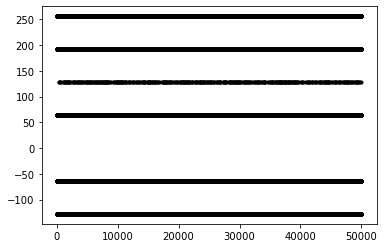

>>>>>>> [(-64, 10212), (64, 10047), (-128, 9893), (192, 9819), (256, 9591), (128, 438)]
Proportion of data in top 10: 1.0
Training X & y:  (45000, 10, 3) (45000, 10)
Validation X & y:  (5000, 10, 3) (5000, 10)


In [11]:
from sklearn.model_selection import train_test_split
import keras

class MyCustomCallback(keras.callbacks.Callback):
    def __init__(self, test_data, k=10):
        self.X_test, self.y_test = test_data
        self.k = k

    def on_train_batch_end(self, batch, logs=None):
        if (batch+1)%300!=0:
            return
        y_test_pred = self.model.predict(self.X_test)
        topk = y_test_pred.argsort()[:, -self.k:]
        acc = 0.
        for i in range(self.y_test.shape[0]):
            if np.argmax(self.y_test[i]) in topk[i]:
                acc += 1.
        print("ACC: ", acc / float(self.y_test.shape[0]))

X, y = create_dataset(addrs, PCs, deltas, num_classes=10, maxlen=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

print("Training X & y: ", X_train.shape, y_train.shape)
print("Validation X & y: ", X_test.shape, y_test.shape)


In [12]:
def get_lstm_model(X_train, y_train, X_test, y_test, rnn_units=32, batch_size=64, maxlen=10, num_labels=3, num_classes=3000, epochs=3, toplot=False):
    input_layer1 = keras.layers.Input(shape=(maxlen, 3, ), name='input1')

    #LSTM Layer 1 with Dropout
    lstm_layer1 = keras.layers.LSTM(rnn_units, return_sequences=True)(input_layer1)
    lstm_layer1 = keras.layers.Dropout(0.2)(lstm_layer1)

    #LSTM Layer 2 with Dropout
#     lstm_layer2 = keras.layers.LSTM(rnn_units)(lstm_layer1)
    lstm_layer2 = keras.layers.LSTM(rnn_units, return_sequences=True)(lstm_layer1)
    lstm_layer2 = keras.layers.Dropout(0.2)(lstm_layer2)

    self_attn1 = SeqSelfAttention(
        attention_width=5,
        attention_activation='sigmoid',
        history_only=False,
        name='SelfAttention1',
        attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL
    )(lstm_layer2)

    self_attn1 = keras.layers.GlobalAveragePooling1D()(self_attn1)
    lstm_out = keras.layers.Lambda(lambda t: t[:,-1])(lstm_layer2)
    penultimate = keras.layers.Concatenate()([lstm_out, self_attn1])
    #Output Layer
    prediction = keras.layers.Dense(num_classes, activation='softmax')(penultimate)

    #Model Inputs and outputs
    model = keras.models.Model(inputs=input_layer1, outputs=prediction)
    #Use Categorical Loss and Accuracy with Adam Optimizer
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print(model.summary())

    #Fit the model to the data
    history = model.fit(X, y, batch_size=batch_size, epochs=epochs, shuffle=False, callbacks=[MyCustomCallback((X_test, y_test), k=4)])

    #Plot the loss curves
    if toplot:
        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train'], loc='upper left')
        plt.show()

    return model

In [13]:
#Use TPU Strategy
with tpu_strategy.scope():
    model = get_lstm_model(X_train, y_train, X_test, y_test, rnn_units=64, batch_size=64, num_classes=10, maxlen=10, epochs=4, toplot=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 10, 3)        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 10, 64)       17408       input1[0][0]                     
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 10, 64)       0           lstm_1[0][0]                     
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 10, 64)       33024       dropout_1[0][0]                  
____________________________________________________________________________________________

KeyboardInterrupt: 

In [ ]:
with open('model_for_cpp_mcf_self_attn.json', 'w') as fout:
    fout.write(model.to_json())
model.save_weights('model_for_cpp_weights_mcf_self_attn.h5', overwrite=True)

In [ ]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'delta_idx_map.json')

In [ ]:
# import numpy as np
# import keras
# import json
# from keras_self_attention import SeqSelfAttention


# def initialize_idx_to_delta(ROOT_DIR="./"):
#   idx_to_delta = None
#   with open(ROOT_DIR + 'delta_idx_map.json') as json_file:
#     idx_to_delta = json.load(json_file)
#   return idx_to_delta

# def initialize_model(ROOT_DIR="./"):
#   f = open(ROOT_DIR + "model_for_cpp_self_attn.json")
#   model = keras.models.model_from_json(f.read(), custom_objects={'SeqSelfAttention': SeqSelfAttention})
#   # tf.keras.models.model_from_json()
#   f.close()
#   model.load_weights(ROOT_DIR + "model_for_cpp_self_attn_weights.h5")
#   model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#   return model

# def prefetch_predict(lastNData) -> int:
#   N = 20
#   if len(lastNData) < 2*N+3:
#     return -1

#   lastNPCs = lastNData[:N]
#   lastNAddrs = lastNData[N:2*N]
#   topk = lastNData[2*N]
#   idx_to_delta = lastNData[2*N+1]
#   model = lastNData[2*N+2]

#   ip1 = 4195632.0
#   ip2 = 8208480.0

#   addr11 = 96935917361984.0
#   addr12 = 195743444536640.0

#   addr21 = 5610901135424.0
#   addr22 = 80904477544064.0

#   addr31 = 222418542097984.0
#   addr32 = 279264050879424.0

#   center1 = 1.61729982e+14
#   center2 = 3.12041036e+13
#   center3 = 2.53453964e+14

#   ips = np.array(lastNPCs)
#   ips = [(ip-ip1)/(ip2-ip1) for ip in ips]

#   def get_cluster_id(center1, center2, center3, point):
#     arr = np.array([abs(center1-point), abs(center2-point), abs(center3-point)])
#     return np.argmin(arr)

#   addrs = np.array(lastNAddrs)
#   cluster_ids = [get_cluster_id(center1, center2, center3, addr) for addr in addrs]

#   addrs[cluster_ids==0] = (addrs[cluster_ids==0] - addr11)/(addr12-addr11)
#   addrs[cluster_ids==1] = (addrs[cluster_ids==1] - addr21)/(addr22-addr21)
#   addrs[cluster_ids==2] = (addrs[cluster_ids==2] - addr31)/(addr32-addr31)

#   X = np.array([list(xx) for xx in zip(ips, cluster_ids, addrs)])
#   X = X.reshape(1, N, 3)

#   y_pred = model.predict(X)
#   topkidxs = y_pred.argsort()[:, -topk:][0]

#   return [idx_to_delta[str(idx)] for idx in topkidxs]
  
# # idx_to_delta = initialize_idx_to_delta(ROOT_DIR)
# # model1 = initialize_model(ROOT_DIR)
# # print(prefetch_predict([0.58037982, 0.58037907, 0.58037982, 0.58037982, 0.58038406, 0.58037982, 0.58037982, 0.58037907, 0.58037982, 0.58037907, 0.58037982, 0.58038406, 0.58037982, 0.58037982, 0.58037982, 0.58038406, 0.58037907, 0.58037982, 0.58037907, 0.58037907, 0.56376003, 0.56376003, 0.56376003, 0.56376001, 0.56376001, 0.56376002, 0.25783423, 0.56376002, 0.25783423, 0.25783423, 0.25783423, 0.56376003, 0.57493763, 0.56376003, 0.56376002, 0.56376002, 0.22437261, 0.56376002, 0.88635157, 0.88635157, 10, idx_to_delta, model1]))